# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Add, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model

from PIL import Image

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work well for:

- Analysis of a time series of sensor data.
- Analysis of signal data over a fixed-length period, for example, an audio recording.
- Natural Language Processing (NLP), although according to my research, Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells might be more promising than CNN as they take into account the proximity of words to create trainable patterns.


CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.

***

**Utility Functions**

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [36]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [5]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [6]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [7]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [8]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [9]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [10]:
# Create X/y arrays
x_train_tfidf = train_tfidf_features.item()
y_train_tfidf = train_tfidf_labels

print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [11]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [12]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


**Define the model and metrics**



In [13]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The generic architecture of the model I've decided to use having two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. 

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

For this model, I will expand upon  a standard configuration of 64 parallel feature maps and a kernel size of 3. The feature maps are the number of times the input is processed or interpreted, whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps.
The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the binary cross entropy loss function will be used given that we are learning a binary classification problem.

Additionally, there are two options to vectorize the data in Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This can be done with the Keras Embeddings Layer, or by using the pretrained embeddings.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This is what we will do with TFIDF and Word2Vec.

In [14]:
x_train_tfidf = x_train_tfidf.todense()
x_test_tfidf = x_test_tfidf.todense()
x_val_tfidf = x_val_tfidf.todense()

In [15]:
x_train_tfidf = np.expand_dims(x_train_tfidf, axis = 2)
x_test_tfidf = np.expand_dims(x_test_tfidf, axis = 2)
x_val_tfidf = np.expand_dims(x_val_tfidf, axis = 2)

In [16]:
def make_model(filters = 16, add_conv_layer = False, kernel_size = 5, dense = 128, dropout = 0.5):
    
    model = Sequential()
#     model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(x_train_tfidf.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    if add_conv_layer:
        model.add(Conv1D(filters=filters*4, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

        model.add(Conv1D(filters=filters*8, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    if dropout:
        model.add(Dropout(rate = dropout))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dropout(rate = dropout))
    else:
        model.add(Dropout(0.1))

    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each of the 2 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = KERAS_METRICS)
    model.summary()
    return model

In [17]:
model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24996, 16)         96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12498, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12494, 16)         1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6247, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 99952)             0         
_________________________________________________________________
dropout (Dropout)            (None, 99952)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

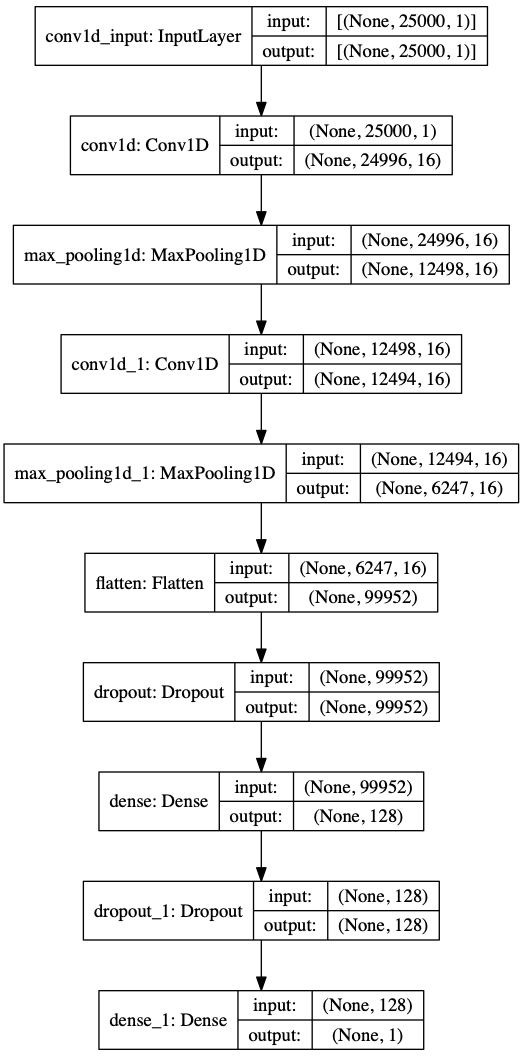

In [18]:
plot_model(model, to_file = 'model_cnn.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_cnn.png')
im

In [23]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 20,
    mode = 'max',
    restore_best_weights = True)

In [24]:
callbacks = [early_stopping]

In [25]:
BATCH_SIZE = 64
EPOCHS = 500

In [26]:
history = model.fit(x_train_tfidf, 
                        y_train_tfidf, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val_tfidf, y_val_tfidf))

Epoch 1/500
855/855 [==============================] - 993s 1s/step - loss: 0.0157 - tp: 27848.0000 - fp: 108.0000 - tn: 26600.0000 - fn: 150.0000 - accuracy: 0.9953 - precision: 0.9961 - recall: 0.9946 - auc: 0.9996 - val_loss: 0.1751 - val_tp: 6729.0000 - val_fp: 264.0000 - val_tn: 6413.0000 - val_fn: 271.0000 - val_accuracy: 0.9609 - val_precision: 0.9622 - val_recall: 0.9613 - val_auc: 0.9857
Epoch 2/500
855/855 [==============================] - 1017s 1s/step - loss: 0.0141 - tp: 27854.0000 - fp: 100.0000 - tn: 26608.0000 - fn: 144.0000 - accuracy: 0.9955 - precision: 0.9964 - recall: 0.9949 - auc: 0.9996 - val_loss: 0.1757 - val_tp: 6714.0000 - val_fp: 282.0000 - val_tn: 6395.0000 - val_fn: 286.0000 - val_accuracy: 0.9585 - val_precision: 0.9597 - val_recall: 0.9591 - val_auc: 0.9863
Epoch 3/500
855/855 [==============================] - 1029s 1s/step - loss: 0.0140 - tp: 27863.0000 - fp: 107.0000 - tn: 26601.0000 - fn: 135.0000 - accuracy: 0.9956 - precision: 0.9962 - recall: 0.

855/855 [==============================] - 1143s 1s/step - loss: 0.0074 - tp: 27913.0000 - fp: 38.0000 - tn: 26670.0000 - fn: 85.0000 - accuracy: 0.9978 - precision: 0.9986 - recall: 0.9970 - auc: 0.9998 - val_loss: 0.2494 - val_tp: 6771.0000 - val_fp: 280.0000 - val_tn: 6397.0000 - val_fn: 229.0000 - val_accuracy: 0.9628 - val_precision: 0.9603 - val_recall: 0.9673 - val_auc: 0.9818
Epoch 42/500
855/855 [==============================] - 1268s 1s/step - loss: 0.0063 - tp: 27935.0000 - fp: 44.0000 - tn: 26664.0000 - fn: 63.0000 - accuracy: 0.9980 - precision: 0.9984 - recall: 0.9977 - auc: 0.9999 - val_loss: 0.2213 - val_tp: 6767.0000 - val_fp: 270.0000 - val_tn: 6407.0000 - val_fn: 233.0000 - val_accuracy: 0.9632 - val_precision: 0.9616 - val_recall: 0.9667 - val_auc: 0.9841
Epoch 43/500
855/855 [==============================] - 1351s 2s/step - loss: 0.0075 - tp: 27914.0000 - fp: 47.0000 - tn: 26661.0000 - fn: 84.0000 - accuracy: 0.9976 - precision: 0.9983 - recall: 0.9970 - auc: 0.9

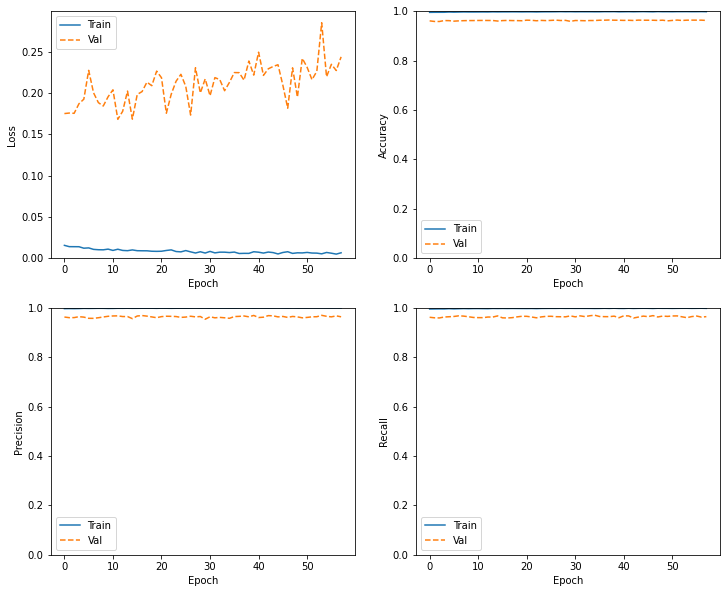

In [37]:
plot_metrics(history)

In [28]:
y_probas_train_tfidf = model.predict(x_train_tfidf)
y_probas_test_tfidf = model.predict(x_test_tfidf)

In [29]:
y_pred_test_tfidf = np.round(y_probas_test_tfidf) 

True Negatives:  3595
False Positives:  115
False Negatives:  117
True Positives:  3772


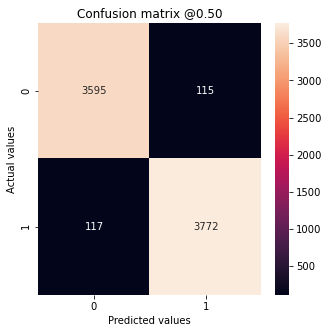

In [30]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [31]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3710
           1       0.97      0.97      0.97      3889

    accuracy                           0.97      7599
   macro avg       0.97      0.97      0.97      7599
weighted avg       0.97      0.97      0.97      7599



In [32]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1_tfidf)

F1: 0.97


In [33]:
# Use predict_proba(X)[:, 1] to extract the probability that samples belong to the bullying class.
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc_tfidf)

AUC: 0.99


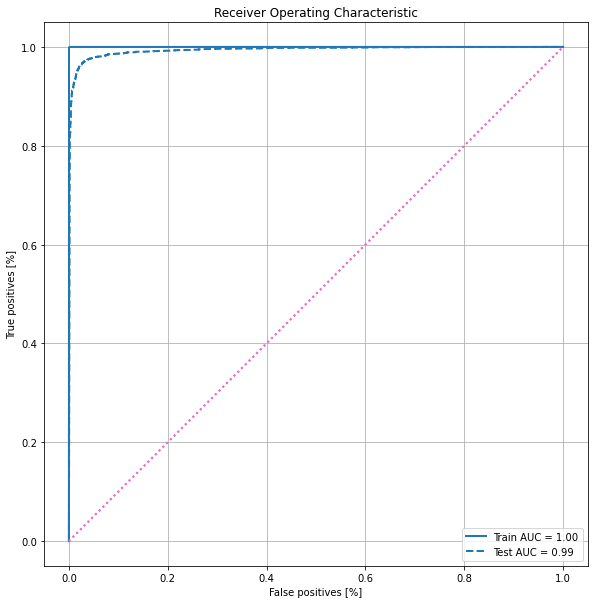

In [34]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

In [35]:
# Saving the model for later import in Streamlit - Heroku.
model.save("cnn/")

INFO:tensorflow:Assets written to: cnn/assets
